# **LG01 - Prediksi Klasifikasi Label Perbaikan - RISTEK FASILKOM UI DATATHON 2025**

---


Setelah Model 1 mengidentifikasi cacat dan Model 2 mengonfirmasi penilaian "Bad" dari operator, Task 3 bertujuan untuk menjawab pertanyaan paling spesifik: "Bagaimana seharusnya komponen yang sudah pasti cacat ini ditangani?"

Tugas ini adalah masalah klasifikasi multikelas di mana kita akan memprediksi RepairLabel (NotPossibleToRepair, FalseScrap, NotYetClassified). Model yang sukses pada tahap ini akan menjadi alat bantu keputusan yang sangat kuat bagi tim perbaikan, memungkinkan mereka untuk memprioritaskan sumber daya dan mengidentifikasi produk yang tidak dapat diselamatkan sejak dini.

## **Import Library & Dataset**

---



In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 20.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss, f1_score
from sklearn.utils.class_weight import compute_class_weight

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import optuna
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

import warnings
warnings.filterwarnings('ignore')


**Upload kaggle.json**

Open Kaggle -> Settings -> Account -> API -> Create New Token -> Upload the file here

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!/bin/bash
!kaggle datasets download rizkyfadhilahjhhhh/dataset-lg01

Dataset URL: https://www.kaggle.com/datasets/rizkyfadhilahjhhhh/dataset-lg01
License(s): unknown
 88% 286M/323M [00:00<00:00, 461MB/s]
100% 323M/323M [00:00<00:00, 463MB/s]


In [ ]:
!unzip dataset-lg01.zip

Archive:  dataset-lg01.zip
  inflating: PCB Dataset/AOI_testing.csv  
  inflating: PCB Dataset/AOI_training.csv  
  inflating: PCB Dataset/SPI_testing_0.csv  
  inflating: PCB Dataset/SPI_testing_1.csv  
  inflating: PCB Dataset/SPI_training_0.csv  
  inflating: PCB Dataset/SPI_training_1.csv  
  inflating: PCB Dataset/SPI_training_2.csv  
  inflating: PCB Dataset/SPI_training_3.csv  


In [ ]:
aoi_train = pd.read_csv('/content/PCB Dataset/AOI_training.csv')
spi_0 = pd.read_csv('/content/PCB Dataset/SPI_training_0.csv')
spi_1 = pd.read_csv('/content/PCB Dataset/SPI_training_1.csv')
spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')
spi_3 = pd.read_csv('/content/PCB Dataset/SPI_training_3.csv')

merged_spi = pd.concat([spi_0, spi_1, spi_2, spi_3])

## **Data Preprocessing & Feature Engineering**

---



Penggabungan Data: Melakukan left join dari data AOI ke data SPI.

Target Engineering: Membuat ketiga variabel target hirarkis, termasuk target_3_repair_label yang menggunakan LabelEncoder untuk mengubah label string menjadi format numerik yang bisa dipahami model.

Feature Engineering: Membuat fitur-fitur yang sama seperti task-task sebelumnya untuk menjaga konsistensi.

In [ ]:
def preprocess_task3_only(spi_df, aoi_df):
    for df in [spi_df, aoi_df]:
        for col in ['FigureID', 'PinNumber']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    spi_df['Datetime'] = pd.to_datetime(spi_df['Date'] + ' ' + spi_df['Time'], errors='coerce')
    merged_cols = ["PanelID", "FigureID", "ComponentID", "PinNumber"]
    df = pd.merge(aoi_df, spi_df, on=merged_cols, how='left')
    df = df[df['Datetime'].notna()].copy()


    df = df[(df['AOILabel'] != 'Soldered') & (df['OperatorLabel'] == 'Bad')].copy()
    df['RepairLabel'] = df['RepairLabel'].fillna("Unknown")

    le = LabelEncoder()
    df['target_repair_label'] = le.fit_transform(df['RepairLabel'])

    df['MachineID'] = df['MachineID'].astype('category').cat.codes
    df['ComponentID_cat'] = df['ComponentID'].astype('category').cat.codes
    df['Shape(um)'] = pd.to_numeric(df['Shape(um)'], errors='coerce')
    df['spi_hour'] = df['Datetime'].dt.hour
    df['spi_dayofweek'] = df['Datetime'].dt.dayofweek
    df['spi_is_weekend'] = (df['spi_dayofweek'] >= 5).astype(int)
    df['offset_magnitude'] = np.sqrt(df['OffsetX(%)']**2 + df['OffsetY(%)']**2)
    df['volume_area_ratio'] = df['Volume(%)'] / (df['Area(%)'] + 1e-6)

    cols_to_drop = [
        'PanelID', 'FigureID', 'PinNumber', 'ComponentID',
        'Date', 'Time', 'Datetime',
        'AOILabel', 'OperatorLabel', 'RepairLabel',
        'MachinePrediction', 'Result',
        'Is_Defect', 'Is_Defect_Label',
        'Volume(um3)', 'Area(um2)'
    ]
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
    return df, le

## **Optimasi Hyperparameter & Pelatihan**

---



Setelah mempersiapkan data, langkah selanjutnya adalah melatih model. Namun, daripada menggunakan hyperparameter default yang mungkin tidak optimal, kami menerapkan proses optimasi hyperparameter otomatis menggunakan Optuna.

In [ ]:
def train_best_model(model_type, X_train, y_train, X_val, y_val, n_classes):
    def objective(trial):
        if model_type == 'catboost':
            params = {
                'iterations': 500,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'depth': trial.suggest_int('depth', 4, 10),
                'loss_function': 'MultiClass',
                'eval_metric': 'TotalF1',
                'verbose': 0,
                'random_seed': 42
            }
            model = cb.CatBoostClassifier(**params)
        elif model_type == 'lightgbm':
            params = {
                'objective': 'multiclass',
                'num_class': n_classes,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'random_state': 42
            }
            model = lgb.LGBMClassifier(**params)
        elif model_type == 'xgboost':
            params = {
                'objective': 'multi:softprob',
                'num_class': n_classes,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'eval_metric': 'mlogloss',
                'seed': 42
            }
            model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        preds = model.predict(X_val)
        return f1_score(y_val, preds, average='macro')
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    best_params = study.best_params

    if model_type == 'catboost':
        best_params.update({'iterations': 500, 'loss_function': 'MultiClass', 'eval_metric': 'TotalF1', 'random_seed': 42, 'verbose': 0, 'early_stopping_rounds': 30})
        model = cb.CatBoostClassifier(**best_params)
    elif model_type == 'lightgbm':
        best_params.update({'objective': 'multiclass', 'num_class': n_classes, 'random_state': 42, 'early_stopping_rounds': 30})
        model = lgb.LGBMClassifier(**best_params)
    elif model_type == 'xgboost':
        best_params.update({'objective': 'multi:softprob', 'num_class': n_classes, 'eval_metric': 'mlogloss', 'seed': 42, 'early_stopping_rounds': 30})
        model = xgb.XGBClassifier(**best_params)

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    return model

## **Pendekatan Alternatif: LSTM**

---



In [ ]:
class PCBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, output_size)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [ ]:
def train_lstm(X_train, y_train, X_val, y_val, n_classes):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    train_loader = DataLoader(PCBDataset(pd.DataFrame(X_train_scaled), y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(PCBDataset(pd.DataFrame(X_val_scaled), y_val), batch_size=64)
    model = LSTMClassifier(input_size=X_train.shape[1], output_size=n_classes)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_val_loss = float('inf')
    patience, counter = 3, 0

    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                loss = loss_fn(model(xb), yb)
                val_losses.append(loss.item())
        avg_val = np.mean(val_losses)
        print(f"Epoch {epoch+1}, Val Loss: {avg_val:.4f}")
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "best_lstm.pt")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(torch.load("best_lstm.pt"))
    return model, scaler, X_val_scaled

## **Fungsi Evaluasi Model**

---



In [ ]:
def evaluate_model(y_true, y_pred, le, name):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Oranges')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## **Persiapan Data untuk Pemodelan**

---



In [ ]:
df, le = preprocess_task3_only(merged_spi, aoi_train)
X = pd.get_dummies(df.drop(columns=['target_repair_label']))
y = df['target_repair_label']
n_classes = len(le.classes_)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## **Pelatihan dan Optimasi Model**

---



In [ ]:
cat_model = train_best_model('catboost', X_train, y_train, X_val, y_val, n_classes)
lgb_model = train_best_model('lightgbm', X_train, y_train, X_val, y_val, n_classes)
xgb_model = train_best_model('xgboost', X_train, y_train, X_val, y_val, n_classes)
lstm_model, scaler_lstm, X_val_scaled = train_lstm(X_train, y_train, X_val, y_val, n_classes)

[I 2025-07-09 08:06:47,819] A new study created in memory with name: no-name-952fad6b-6f72-4093-8e50-bb8ab62297ae
[I 2025-07-09 08:07:30,452] Trial 0 finished with value: 0.7910619244741066 and parameters: {'learning_rate': 0.015328728300065859, 'depth': 10}. Best is trial 0 with value: 0.7910619244741066.
[I 2025-07-09 08:07:41,083] Trial 1 finished with value: 0.772735760971055 and parameters: {'learning_rate': 0.05203824501684755, 'depth': 8}. Best is trial 0 with value: 0.7910619244741066.
[I 2025-07-09 08:07:42,097] Trial 2 finished with value: 0.772735760971055 and parameters: {'learning_rate': 0.014568810277666714, 'depth': 4}. Best is trial 0 with value: 0.7910619244741066.
[I 2025-07-09 08:07:43,156] Trial 3 finished with value: 0.772735760971055 and parameters: {'learning_rate': 0.01088260876195287, 'depth': 4}. Best is trial 0 with value: 0.7910619244741066.
[I 2025-07-09 08:07:46,122] Trial 4 finished with value: 0.796209962245768 and parameters: {'learning_rate': 0.0836999

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-09 08:11:21,212] Trial 1 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.04888195699422886, 'max_depth': 9}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:21,369] Trial 2 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.06336054160097751, 'max_depth': 9}. Best is trial 1 with value: 0.7994142200708548.
[I 2025-07-09 08:11:21,458] Trial 3 finished with value: 0.7698972254375812 and parameters: {'learning_rate': 0.034554252534813604, 'max_depth': 4}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:21,604] Trial 4 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.0288040957955894, 'max_depth': 8}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:21,746] Trial 5 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.04423644528129291, 'max_depth': 6}. Best is trial 1 with value: 0.7994142200708548.
[I 2025-07-09 08:11:21,829] Trial 6 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.0567018744105467, 'max_depth': 4}. Best is trial 1 with value: 0.7994142200708548.
[I 2025-07-09 08:11:21,913] Trial 7 finished with value: 0.7698972254375812 and parameters: {'learning_rate': 0.0987603458758449, 'max_depth': 4}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-09 08:11:22,055] Trial 8 finished with value: 0.7522095837885311 and parameters: {'learning_rate': 0.09368424724572781, 'max_depth': 7}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:22,185] Trial 9 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.03459317250704722, 'max_depth': 6}. Best is trial 1 with value: 0.7994142200708548.
[I 2025-07-09 08:11:22,349] Trial 10 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.07450549751723243, 'max_depth': 10}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-09 08:11:22,488] Trial 11 finished with value: 0.7541749283983256 and parameters: {'learning_rate': 0.012945664368883683, 'max_depth': 9}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:22,651] Trial 12 finished with value: 0.7698972254375812 and parameters: {'learning_rate': 0.06544881417132108, 'max_depth': 8}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:22,841] Trial 13 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.07882572456359031, 'max_depth': 9}. Best is trial 1 with value: 0.7994142200708548.
[I 2025-07-09 08:11:22,997] Trial 14 finished with value: 0.755296371422132 and parameters: {'learning_rate': 0.05729218041714711, 'max_depth': 9}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-07-09 08:11:23,154] Trial 15 finished with value: 0.7823529411764705 and parameters: {'learning_rate': 0.07230026575820252, 'max_depth': 8}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:23,330] Trial 16 finished with value: 0.7739184562713975 and parameters: {'learning_rate': 0.08652870839852372, 'max_depth': 10}. Best is trial 1 with value: 0.7994142200708548.
[I 2025-07-09 08:11:23,452] Trial 17 finished with value: 0.7813068730316987 and parameters: {'learning_rate': 0.018207594182585267, 'max_depth': 7}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:23,619] Trial 18 finished with value: 0.7906585636203799 and parameters: {'learning_rate': 0.06455407134925244, 'max_depth': 9}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-09 08:11:23,755] Trial 19 finished with value: 0.7698972254375812 and parameters: {'learning_rate': 0.04677053385253098, 'max_depth': 6}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 08:11:23,874] A new study created in memory with name: no-name-febdbd06-dd4d-418c-acb2-b7012cf0746c


[0]	validation_0-mlogloss:1.08216
[1]	validation_0-mlogloss:1.06641
[2]	validation_0-mlogloss:1.05097
[3]	validation_0-mlogloss:1.03588
[4]	validation_0-mlogloss:1.02136
[5]	validation_0-mlogloss:1.00711
[6]	validation_0-mlogloss:0.99316
[7]	validation_0-mlogloss:0.97955
[8]	validation_0-mlogloss:0.96656
[9]	validation_0-mlogloss:0.95364
[10]	validation_0-mlogloss:0.94123
[11]	validation_0-mlogloss:0.92881
[12]	validation_0-mlogloss:0.91706
[13]	validation_0-mlogloss:0.90524
[14]	validation_0-mlogloss:0.89391
[15]	validation_0-mlogloss:0.88283
[16]	validation_0-mlogloss:0.87212
[17]	validation_0-mlogloss:0.86145
[18]	validation_0-mlogloss:0.85111
[19]	validation_0-mlogloss:0.84114
[20]	validation_0-mlogloss:0.83111
[21]	validation_0-mlogloss:0.82156
[22]	validation_0-mlogloss:0.81211
[23]	validation_0-mlogloss:0.80309
[24]	validation_0-mlogloss:0.79414
[25]	validation_0-mlogloss:0.78534
[26]	validation_0-mlogloss:0.77702
[27]	validation_0-mlogloss:0.76851
[28]	validation_0-mlogloss:0.7

[I 2025-07-09 08:11:25,312] Trial 0 finished with value: 0.7145721925133689 and parameters: {'learning_rate': 0.015489153319842781, 'max_depth': 7}. Best is trial 0 with value: 0.7145721925133689.


[0]	validation_0-mlogloss:1.00016
[1]	validation_0-mlogloss:0.92074
[2]	validation_0-mlogloss:0.85054
[3]	validation_0-mlogloss:0.79081
[4]	validation_0-mlogloss:0.73950
[5]	validation_0-mlogloss:0.69406
[6]	validation_0-mlogloss:0.65532
[7]	validation_0-mlogloss:0.62052
[8]	validation_0-mlogloss:0.59180
[9]	validation_0-mlogloss:0.56499
[10]	validation_0-mlogloss:0.54239
[11]	validation_0-mlogloss:0.52300
[12]	validation_0-mlogloss:0.50498
[13]	validation_0-mlogloss:0.48753
[14]	validation_0-mlogloss:0.47051
[15]	validation_0-mlogloss:0.45373
[16]	validation_0-mlogloss:0.43968
[17]	validation_0-mlogloss:0.42518
[18]	validation_0-mlogloss:0.41283
[19]	validation_0-mlogloss:0.40248
[20]	validation_0-mlogloss:0.39118
[21]	validation_0-mlogloss:0.38274
[22]	validation_0-mlogloss:0.37601
[23]	validation_0-mlogloss:0.36968
[24]	validation_0-mlogloss:0.36425
[25]	validation_0-mlogloss:0.35963
[26]	validation_0-mlogloss:0.35550
[27]	validation_0-mlogloss:0.35201
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:26,237] Trial 1 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.09579012635413772, 'max_depth': 7}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.08280
[1]	validation_0-mlogloss:1.06765
[2]	validation_0-mlogloss:1.05283
[3]	validation_0-mlogloss:1.03830
[4]	validation_0-mlogloss:1.02432
[5]	validation_0-mlogloss:1.01053
[6]	validation_0-mlogloss:0.99724
[7]	validation_0-mlogloss:0.98417
[8]	validation_0-mlogloss:0.97169
[9]	validation_0-mlogloss:0.95924
[10]	validation_0-mlogloss:0.94715
[11]	validation_0-mlogloss:0.93511
[12]	validation_0-mlogloss:0.92368
[13]	validation_0-mlogloss:0.91217
[14]	validation_0-mlogloss:0.90123
[15]	validation_0-mlogloss:0.89042
[16]	validation_0-mlogloss:0.87985
[17]	validation_0-mlogloss:0.86954
[18]	validation_0-mlogloss:0.85935
[19]	validation_0-mlogloss:0.84963
[20]	validation_0-mlogloss:0.83983
[21]	validation_0-mlogloss:0.83040
[22]	validation_0-mlogloss:0.82112
[23]	validation_0-mlogloss:0.81227
[24]	validation_0-mlogloss:0.80343
[25]	validation_0-mlogloss:0.79487
[26]	validation_0-mlogloss:0.78658
[27]	validation_0-mlogloss:0.77832
[28]	validation_0-mlogloss:0.7

[I 2025-07-09 08:11:27,543] Trial 2 finished with value: 0.7040692640692642 and parameters: {'learning_rate': 0.014879121197560678, 'max_depth': 9}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.02350
[1]	validation_0-mlogloss:0.95942
[2]	validation_0-mlogloss:0.90167
[3]	validation_0-mlogloss:0.85072
[4]	validation_0-mlogloss:0.80513
[5]	validation_0-mlogloss:0.76398
[6]	validation_0-mlogloss:0.72757
[7]	validation_0-mlogloss:0.69362
[8]	validation_0-mlogloss:0.66453
[9]	validation_0-mlogloss:0.63767
[10]	validation_0-mlogloss:0.61342
[11]	validation_0-mlogloss:0.59097
[12]	validation_0-mlogloss:0.57117
[13]	validation_0-mlogloss:0.55255
[14]	validation_0-mlogloss:0.53632
[15]	validation_0-mlogloss:0.52166
[16]	validation_0-mlogloss:0.50732
[17]	validation_0-mlogloss:0.49501
[18]	validation_0-mlogloss:0.48267
[19]	validation_0-mlogloss:0.47192
[20]	validation_0-mlogloss:0.46080
[21]	validation_0-mlogloss:0.45057
[22]	validation_0-mlogloss:0.44110
[23]	validation_0-mlogloss:0.43160
[24]	validation_0-mlogloss:0.42322
[25]	validation_0-mlogloss:0.41554
[26]	validation_0-mlogloss:0.40951
[27]	validation_0-mlogloss:0.40398
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:28,489] Trial 3 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.07236163288213665, 'max_depth': 8}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.08464
[1]	validation_0-mlogloss:1.07122
[2]	validation_0-mlogloss:1.05801
[3]	validation_0-mlogloss:1.04507
[4]	validation_0-mlogloss:1.03253
[5]	validation_0-mlogloss:1.02015
[6]	validation_0-mlogloss:1.00819
[7]	validation_0-mlogloss:0.99642
[8]	validation_0-mlogloss:0.98504
[9]	validation_0-mlogloss:0.97369
[10]	validation_0-mlogloss:0.96278
[11]	validation_0-mlogloss:0.95186
[12]	validation_0-mlogloss:0.94140
[13]	validation_0-mlogloss:0.93089
[14]	validation_0-mlogloss:0.92074
[15]	validation_0-mlogloss:0.91069
[16]	validation_0-mlogloss:0.90090
[17]	validation_0-mlogloss:0.89130
[18]	validation_0-mlogloss:0.88197
[19]	validation_0-mlogloss:0.87277
[20]	validation_0-mlogloss:0.86393
[21]	validation_0-mlogloss:0.85490
[22]	validation_0-mlogloss:0.84654
[23]	validation_0-mlogloss:0.83799
[24]	validation_0-mlogloss:0.82964
[25]	validation_0-mlogloss:0.82153
[26]	validation_0-mlogloss:0.81362
[27]	validation_0-mlogloss:0.80583
[28]	validation_0-mlogloss:0.7

[I 2025-07-09 08:11:30,224] Trial 4 finished with value: 0.6966754717879157 and parameters: {'learning_rate': 0.013139711183720785, 'max_depth': 8}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.07359
[1]	validation_0-mlogloss:1.04949
[2]	validation_0-mlogloss:1.02655
[3]	validation_0-mlogloss:1.00443
[4]	validation_0-mlogloss:0.98336
[5]	validation_0-mlogloss:0.96300
[6]	validation_0-mlogloss:0.94350
[7]	validation_0-mlogloss:0.92464
[8]	validation_0-mlogloss:0.90680
[9]	validation_0-mlogloss:0.88951
[10]	validation_0-mlogloss:0.87303
[11]	validation_0-mlogloss:0.85722
[12]	validation_0-mlogloss:0.84228
[13]	validation_0-mlogloss:0.82762
[14]	validation_0-mlogloss:0.81322
[15]	validation_0-mlogloss:0.79960
[16]	validation_0-mlogloss:0.78620
[17]	validation_0-mlogloss:0.77354
[18]	validation_0-mlogloss:0.76092
[19]	validation_0-mlogloss:0.74927
[20]	validation_0-mlogloss:0.73774
[21]	validation_0-mlogloss:0.72632
[22]	validation_0-mlogloss:0.71555
[23]	validation_0-mlogloss:0.70494
[24]	validation_0-mlogloss:0.69483
[25]	validation_0-mlogloss:0.68469
[26]	validation_0-mlogloss:0.67491
[27]	validation_0-mlogloss:0.66541
[28]	validation_0-mlogloss:0.6

[I 2025-07-09 08:11:31,612] Trial 5 finished with value: 0.7523714333309536 and parameters: {'learning_rate': 0.024171338772364354, 'max_depth': 4}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.00944
[1]	validation_0-mlogloss:0.93323
[2]	validation_0-mlogloss:0.86804
[3]	validation_0-mlogloss:0.81246
[4]	validation_0-mlogloss:0.76409
[5]	validation_0-mlogloss:0.72099
[6]	validation_0-mlogloss:0.68321
[7]	validation_0-mlogloss:0.64765
[8]	validation_0-mlogloss:0.61583
[9]	validation_0-mlogloss:0.58856
[10]	validation_0-mlogloss:0.56252
[11]	validation_0-mlogloss:0.53962
[12]	validation_0-mlogloss:0.51955
[13]	validation_0-mlogloss:0.50146
[14]	validation_0-mlogloss:0.48441
[15]	validation_0-mlogloss:0.46561
[16]	validation_0-mlogloss:0.44805
[17]	validation_0-mlogloss:0.43272
[18]	validation_0-mlogloss:0.41770
[19]	validation_0-mlogloss:0.40571
[20]	validation_0-mlogloss:0.39574
[21]	validation_0-mlogloss:0.38666
[22]	validation_0-mlogloss:0.37806
[23]	validation_0-mlogloss:0.37214
[24]	validation_0-mlogloss:0.36571
[25]	validation_0-mlogloss:0.35848
[26]	validation_0-mlogloss:0.35464
[27]	validation_0-mlogloss:0.34885
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:33,041] Trial 6 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.08842395565710558, 'max_depth': 4}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.05634
[1]	validation_0-mlogloss:1.01772
[2]	validation_0-mlogloss:0.98173
[3]	validation_0-mlogloss:0.94769
[4]	validation_0-mlogloss:0.91613
[5]	validation_0-mlogloss:0.88609
[6]	validation_0-mlogloss:0.85826
[7]	validation_0-mlogloss:0.83175
[8]	validation_0-mlogloss:0.80737
[9]	validation_0-mlogloss:0.78374
[10]	validation_0-mlogloss:0.76246
[11]	validation_0-mlogloss:0.74180
[12]	validation_0-mlogloss:0.72279
[13]	validation_0-mlogloss:0.70414
[14]	validation_0-mlogloss:0.68681
[15]	validation_0-mlogloss:0.67036
[16]	validation_0-mlogloss:0.65503
[17]	validation_0-mlogloss:0.64087
[18]	validation_0-mlogloss:0.62707
[19]	validation_0-mlogloss:0.61405
[20]	validation_0-mlogloss:0.60145
[21]	validation_0-mlogloss:0.58964
[22]	validation_0-mlogloss:0.57859
[23]	validation_0-mlogloss:0.56785
[24]	validation_0-mlogloss:0.55807
[25]	validation_0-mlogloss:0.54883
[26]	validation_0-mlogloss:0.53948
[27]	validation_0-mlogloss:0.53125
[28]	validation_0-mlogloss:0.5

[I 2025-07-09 08:11:35,807] Trial 7 finished with value: 0.7269264069264069 and parameters: {'learning_rate': 0.04018644894341779, 'max_depth': 7}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.08635
[1]	validation_0-mlogloss:1.07452
[2]	validation_0-mlogloss:1.06285
[3]	validation_0-mlogloss:1.05136
[4]	validation_0-mlogloss:1.04019
[5]	validation_0-mlogloss:1.02919
[6]	validation_0-mlogloss:1.01839
[7]	validation_0-mlogloss:1.00782
[8]	validation_0-mlogloss:0.99748
[9]	validation_0-mlogloss:0.98722
[10]	validation_0-mlogloss:0.97735
[11]	validation_0-mlogloss:0.96751
[12]	validation_0-mlogloss:0.95808
[13]	validation_0-mlogloss:0.94858
[14]	validation_0-mlogloss:0.93933
[15]	validation_0-mlogloss:0.93026
[16]	validation_0-mlogloss:0.92132
[17]	validation_0-mlogloss:0.91249
[18]	validation_0-mlogloss:0.90389
[19]	validation_0-mlogloss:0.89552
[20]	validation_0-mlogloss:0.88728
[21]	validation_0-mlogloss:0.87899
[22]	validation_0-mlogloss:0.87104
[23]	validation_0-mlogloss:0.86309
[24]	validation_0-mlogloss:0.85543
[25]	validation_0-mlogloss:0.84783
[26]	validation_0-mlogloss:0.84037
[27]	validation_0-mlogloss:0.83301
[28]	validation_0-mlogloss:0.8

[I 2025-07-09 08:11:37,282] Trial 8 finished with value: 0.6896963024130653 and parameters: {'learning_rate': 0.011527499700631395, 'max_depth': 7}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.01528
[1]	validation_0-mlogloss:0.94521
[2]	validation_0-mlogloss:0.88297
[3]	validation_0-mlogloss:0.82873
[4]	validation_0-mlogloss:0.78079
[5]	validation_0-mlogloss:0.73754
[6]	validation_0-mlogloss:0.69968
[7]	validation_0-mlogloss:0.66610
[8]	validation_0-mlogloss:0.63629
[9]	validation_0-mlogloss:0.60832
[10]	validation_0-mlogloss:0.58463
[11]	validation_0-mlogloss:0.56293
[12]	validation_0-mlogloss:0.54410
[13]	validation_0-mlogloss:0.52671
[14]	validation_0-mlogloss:0.51036
[15]	validation_0-mlogloss:0.49655
[16]	validation_0-mlogloss:0.48334
[17]	validation_0-mlogloss:0.47099
[18]	validation_0-mlogloss:0.45809
[19]	validation_0-mlogloss:0.44771
[20]	validation_0-mlogloss:0.43688
[21]	validation_0-mlogloss:0.42671
[22]	validation_0-mlogloss:0.41705
[23]	validation_0-mlogloss:0.40961
[24]	validation_0-mlogloss:0.40254
[25]	validation_0-mlogloss:0.39631
[26]	validation_0-mlogloss:0.38921
[27]	validation_0-mlogloss:0.38398
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:38,253] Trial 9 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.08056132845536298, 'max_depth': 9}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.03494
[1]	validation_0-mlogloss:0.97835
[2]	validation_0-mlogloss:0.92771
[3]	validation_0-mlogloss:0.88188
[4]	validation_0-mlogloss:0.84025
[5]	validation_0-mlogloss:0.80258
[6]	validation_0-mlogloss:0.76798
[7]	validation_0-mlogloss:0.73664
[8]	validation_0-mlogloss:0.70841
[9]	validation_0-mlogloss:0.68179
[10]	validation_0-mlogloss:0.65757
[11]	validation_0-mlogloss:0.63553
[12]	validation_0-mlogloss:0.61440
[13]	validation_0-mlogloss:0.59493
[14]	validation_0-mlogloss:0.57742
[15]	validation_0-mlogloss:0.56068
[16]	validation_0-mlogloss:0.54561
[17]	validation_0-mlogloss:0.53065
[18]	validation_0-mlogloss:0.51638
[19]	validation_0-mlogloss:0.50305
[20]	validation_0-mlogloss:0.49089
[21]	validation_0-mlogloss:0.47853
[22]	validation_0-mlogloss:0.46765
[23]	validation_0-mlogloss:0.45690
[24]	validation_0-mlogloss:0.44763
[25]	validation_0-mlogloss:0.43810
[26]	validation_0-mlogloss:0.42924
[27]	validation_0-mlogloss:0.42109
[28]	validation_0-mlogloss:0.4

[I 2025-07-09 08:11:39,181] Trial 10 finished with value: 0.755296371422132 and parameters: {'learning_rate': 0.06090326669612884, 'max_depth': 5}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.00206
[1]	validation_0-mlogloss:0.92194
[2]	validation_0-mlogloss:0.85317
[3]	validation_0-mlogloss:0.79424
[4]	validation_0-mlogloss:0.74353
[5]	validation_0-mlogloss:0.69920
[6]	validation_0-mlogloss:0.65998
[7]	validation_0-mlogloss:0.62632
[8]	validation_0-mlogloss:0.59621
[9]	validation_0-mlogloss:0.56892
[10]	validation_0-mlogloss:0.54494
[11]	validation_0-mlogloss:0.52265
[12]	validation_0-mlogloss:0.50144
[13]	validation_0-mlogloss:0.48324
[14]	validation_0-mlogloss:0.46584
[15]	validation_0-mlogloss:0.45054
[16]	validation_0-mlogloss:0.43724
[17]	validation_0-mlogloss:0.42337
[18]	validation_0-mlogloss:0.41133
[19]	validation_0-mlogloss:0.40089
[20]	validation_0-mlogloss:0.39105
[21]	validation_0-mlogloss:0.38301
[22]	validation_0-mlogloss:0.37703
[23]	validation_0-mlogloss:0.37121
[24]	validation_0-mlogloss:0.36605
[25]	validation_0-mlogloss:0.36016
[26]	validation_0-mlogloss:0.35626
[27]	validation_0-mlogloss:0.35338
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:40,178] Trial 11 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.09362500548144509, 'max_depth': 5}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:0.99629
[1]	validation_0-mlogloss:0.91323
[2]	validation_0-mlogloss:0.84172
[3]	validation_0-mlogloss:0.78080
[4]	validation_0-mlogloss:0.72951
[5]	validation_0-mlogloss:0.68542
[6]	validation_0-mlogloss:0.64633
[7]	validation_0-mlogloss:0.61214
[8]	validation_0-mlogloss:0.58306
[9]	validation_0-mlogloss:0.55679
[10]	validation_0-mlogloss:0.53473
[11]	validation_0-mlogloss:0.51270
[12]	validation_0-mlogloss:0.49256
[13]	validation_0-mlogloss:0.47437
[14]	validation_0-mlogloss:0.45748
[15]	validation_0-mlogloss:0.44241
[16]	validation_0-mlogloss:0.42696
[17]	validation_0-mlogloss:0.41435
[18]	validation_0-mlogloss:0.40358
[19]	validation_0-mlogloss:0.39371
[20]	validation_0-mlogloss:0.38425
[21]	validation_0-mlogloss:0.37702
[22]	validation_0-mlogloss:0.37158
[23]	validation_0-mlogloss:0.36492
[24]	validation_0-mlogloss:0.36055
[25]	validation_0-mlogloss:0.35505
[26]	validation_0-mlogloss:0.35183
[27]	validation_0-mlogloss:0.34866
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:41,284] Trial 12 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.09972911460846905, 'max_depth': 6}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:0.99736
[1]	validation_0-mlogloss:0.91410
[2]	validation_0-mlogloss:0.84319
[3]	validation_0-mlogloss:0.78285
[4]	validation_0-mlogloss:0.73171
[5]	validation_0-mlogloss:0.68698
[6]	validation_0-mlogloss:0.64782
[7]	validation_0-mlogloss:0.61321
[8]	validation_0-mlogloss:0.58317
[9]	validation_0-mlogloss:0.55603
[10]	validation_0-mlogloss:0.53097
[11]	validation_0-mlogloss:0.50808
[12]	validation_0-mlogloss:0.48787
[13]	validation_0-mlogloss:0.46976
[14]	validation_0-mlogloss:0.45290
[15]	validation_0-mlogloss:0.43812
[16]	validation_0-mlogloss:0.42269
[17]	validation_0-mlogloss:0.41020
[18]	validation_0-mlogloss:0.39931
[19]	validation_0-mlogloss:0.38910
[20]	validation_0-mlogloss:0.38058
[21]	validation_0-mlogloss:0.37280
[22]	validation_0-mlogloss:0.36704
[23]	validation_0-mlogloss:0.36159
[24]	validation_0-mlogloss:0.35665
[25]	validation_0-mlogloss:0.35201
[26]	validation_0-mlogloss:0.34808
[27]	validation_0-mlogloss:0.34605
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:42,562] Trial 13 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.09837500916529483, 'max_depth': 5}. Best is trial 1 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.02563
[1]	validation_0-mlogloss:0.96306
[2]	validation_0-mlogloss:0.90710
[3]	validation_0-mlogloss:0.85620
[4]	validation_0-mlogloss:0.81166
[5]	validation_0-mlogloss:0.77158
[6]	validation_0-mlogloss:0.73542
[7]	validation_0-mlogloss:0.70268
[8]	validation_0-mlogloss:0.67346
[9]	validation_0-mlogloss:0.64674
[10]	validation_0-mlogloss:0.62216
[11]	validation_0-mlogloss:0.60065
[12]	validation_0-mlogloss:0.58102
[13]	validation_0-mlogloss:0.56277
[14]	validation_0-mlogloss:0.54546
[15]	validation_0-mlogloss:0.53052
[16]	validation_0-mlogloss:0.51519
[17]	validation_0-mlogloss:0.50125
[18]	validation_0-mlogloss:0.48766
[19]	validation_0-mlogloss:0.47438
[20]	validation_0-mlogloss:0.46213
[21]	validation_0-mlogloss:0.45060
[22]	validation_0-mlogloss:0.44019
[23]	validation_0-mlogloss:0.43036
[24]	validation_0-mlogloss:0.42182
[25]	validation_0-mlogloss:0.41467
[26]	validation_0-mlogloss:0.40675
[27]	validation_0-mlogloss:0.39949
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:44,023] Trial 14 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.07025130773501494, 'max_depth': 6}. Best is trial 14 with value: 0.7994142200708548.


[0]	validation_0-mlogloss:1.03194
[1]	validation_0-mlogloss:0.97369
[2]	validation_0-mlogloss:0.92151
[3]	validation_0-mlogloss:0.87379
[4]	validation_0-mlogloss:0.83173
[5]	validation_0-mlogloss:0.79294
[6]	validation_0-mlogloss:0.75791
[7]	validation_0-mlogloss:0.72587
[8]	validation_0-mlogloss:0.69741
[9]	validation_0-mlogloss:0.67118
[10]	validation_0-mlogloss:0.64676
[11]	validation_0-mlogloss:0.62438
[12]	validation_0-mlogloss:0.60442
[13]	validation_0-mlogloss:0.58566
[14]	validation_0-mlogloss:0.56843
[15]	validation_0-mlogloss:0.55278
[16]	validation_0-mlogloss:0.53807
[17]	validation_0-mlogloss:0.52499
[18]	validation_0-mlogloss:0.51154
[19]	validation_0-mlogloss:0.49891
[20]	validation_0-mlogloss:0.48676
[21]	validation_0-mlogloss:0.47491
[22]	validation_0-mlogloss:0.46304
[23]	validation_0-mlogloss:0.45222
[24]	validation_0-mlogloss:0.44283
[25]	validation_0-mlogloss:0.43350
[26]	validation_0-mlogloss:0.42422
[27]	validation_0-mlogloss:0.41691
[28]	validation_0-mlogloss:0.4

[I 2025-07-09 08:11:45,425] Trial 15 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.06400861624084372, 'max_depth': 6}. Best is trial 14 with value: 0.7994142200708548.


[0]	validation_0-mlogloss:1.04687
[1]	validation_0-mlogloss:1.00039
[2]	validation_0-mlogloss:0.95791
[3]	validation_0-mlogloss:0.91818
[4]	validation_0-mlogloss:0.88195
[5]	validation_0-mlogloss:0.84795
[6]	validation_0-mlogloss:0.81671
[7]	validation_0-mlogloss:0.78701
[8]	validation_0-mlogloss:0.76063
[9]	validation_0-mlogloss:0.73535
[10]	validation_0-mlogloss:0.71207
[11]	validation_0-mlogloss:0.69029
[12]	validation_0-mlogloss:0.67044
[13]	validation_0-mlogloss:0.65122
[14]	validation_0-mlogloss:0.63369
[15]	validation_0-mlogloss:0.61704
[16]	validation_0-mlogloss:0.60125
[17]	validation_0-mlogloss:0.58716
[18]	validation_0-mlogloss:0.57326
[19]	validation_0-mlogloss:0.56058
[20]	validation_0-mlogloss:0.54884
[21]	validation_0-mlogloss:0.53773
[22]	validation_0-mlogloss:0.52724
[23]	validation_0-mlogloss:0.51750
[24]	validation_0-mlogloss:0.50793
[25]	validation_0-mlogloss:0.49951
[26]	validation_0-mlogloss:0.49114
[27]	validation_0-mlogloss:0.48309
[28]	validation_0-mlogloss:0.4

[I 2025-07-09 08:11:46,968] Trial 16 finished with value: 0.7269264069264069 and parameters: {'learning_rate': 0.04937499071922014, 'max_depth': 10}. Best is trial 14 with value: 0.7994142200708548.


[0]	validation_0-mlogloss:1.01422
[1]	validation_0-mlogloss:0.94342
[2]	validation_0-mlogloss:0.88103
[3]	validation_0-mlogloss:0.82605
[4]	validation_0-mlogloss:0.77812
[5]	validation_0-mlogloss:0.73518
[6]	validation_0-mlogloss:0.69790
[7]	validation_0-mlogloss:0.66388
[8]	validation_0-mlogloss:0.63460
[9]	validation_0-mlogloss:0.60700
[10]	validation_0-mlogloss:0.58328
[11]	validation_0-mlogloss:0.56129
[12]	validation_0-mlogloss:0.54284
[13]	validation_0-mlogloss:0.52515
[14]	validation_0-mlogloss:0.50796
[15]	validation_0-mlogloss:0.49205
[16]	validation_0-mlogloss:0.47656
[17]	validation_0-mlogloss:0.46255
[18]	validation_0-mlogloss:0.44960
[19]	validation_0-mlogloss:0.43806
[20]	validation_0-mlogloss:0.42612
[21]	validation_0-mlogloss:0.41745
[22]	validation_0-mlogloss:0.40833
[23]	validation_0-mlogloss:0.39942
[24]	validation_0-mlogloss:0.39154
[25]	validation_0-mlogloss:0.38475
[26]	validation_0-mlogloss:0.37729
[27]	validation_0-mlogloss:0.37273
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:48,409] Trial 17 finished with value: 0.8086773206392385 and parameters: {'learning_rate': 0.08161651315398544, 'max_depth': 6}. Best is trial 17 with value: 0.8086773206392385.


[0]	validation_0-mlogloss:1.01891
[1]	validation_0-mlogloss:0.95144
[2]	validation_0-mlogloss:0.89152
[3]	validation_0-mlogloss:0.83823
[4]	validation_0-mlogloss:0.79124
[5]	validation_0-mlogloss:0.74929
[6]	validation_0-mlogloss:0.71365
[7]	validation_0-mlogloss:0.68071
[8]	validation_0-mlogloss:0.65053
[9]	validation_0-mlogloss:0.62393
[10]	validation_0-mlogloss:0.60054
[11]	validation_0-mlogloss:0.57883
[12]	validation_0-mlogloss:0.55905
[13]	validation_0-mlogloss:0.54098
[14]	validation_0-mlogloss:0.52484
[15]	validation_0-mlogloss:0.50896
[16]	validation_0-mlogloss:0.49406
[17]	validation_0-mlogloss:0.47980
[18]	validation_0-mlogloss:0.46546
[19]	validation_0-mlogloss:0.45278
[20]	validation_0-mlogloss:0.44060
[21]	validation_0-mlogloss:0.42913
[22]	validation_0-mlogloss:0.41999
[23]	validation_0-mlogloss:0.41056
[24]	validation_0-mlogloss:0.40187
[25]	validation_0-mlogloss:0.39403
[26]	validation_0-mlogloss:0.38637
[27]	validation_0-mlogloss:0.38086
[28]	validation_0-mlogloss:0.3

[I 2025-07-09 08:11:49,879] Trial 18 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.07693491131725104, 'max_depth': 6}. Best is trial 17 with value: 0.8086773206392385.


[0]	validation_0-mlogloss:1.04712
[1]	validation_0-mlogloss:1.00084
[2]	validation_0-mlogloss:0.95832
[3]	validation_0-mlogloss:0.91906
[4]	validation_0-mlogloss:0.88270
[5]	validation_0-mlogloss:0.84912
[6]	validation_0-mlogloss:0.81818
[7]	validation_0-mlogloss:0.78871
[8]	validation_0-mlogloss:0.76285
[9]	validation_0-mlogloss:0.73737
[10]	validation_0-mlogloss:0.71468
[11]	validation_0-mlogloss:0.69311
[12]	validation_0-mlogloss:0.67274
[13]	validation_0-mlogloss:0.65430
[14]	validation_0-mlogloss:0.63662
[15]	validation_0-mlogloss:0.62054
[16]	validation_0-mlogloss:0.60497
[17]	validation_0-mlogloss:0.59064
[18]	validation_0-mlogloss:0.57741
[19]	validation_0-mlogloss:0.56435
[20]	validation_0-mlogloss:0.55254
[21]	validation_0-mlogloss:0.54120
[22]	validation_0-mlogloss:0.53002
[23]	validation_0-mlogloss:0.51934
[24]	validation_0-mlogloss:0.50926
[25]	validation_0-mlogloss:0.49987
[26]	validation_0-mlogloss:0.49037
[27]	validation_0-mlogloss:0.48114
[28]	validation_0-mlogloss:0.4

[I 2025-07-09 08:11:51,519] Trial 19 finished with value: 0.7523714333309536 and parameters: {'learning_rate': 0.04913733621665767, 'max_depth': 6}. Best is trial 17 with value: 0.8086773206392385.


[0]	validation_0-mlogloss:1.01422
[1]	validation_0-mlogloss:0.94342
[2]	validation_0-mlogloss:0.88103
[3]	validation_0-mlogloss:0.82605
[4]	validation_0-mlogloss:0.77812
[5]	validation_0-mlogloss:0.73518
[6]	validation_0-mlogloss:0.69790
[7]	validation_0-mlogloss:0.66388
[8]	validation_0-mlogloss:0.63460
[9]	validation_0-mlogloss:0.60700
[10]	validation_0-mlogloss:0.58328
[11]	validation_0-mlogloss:0.56129
[12]	validation_0-mlogloss:0.54284
[13]	validation_0-mlogloss:0.52515
[14]	validation_0-mlogloss:0.50796
[15]	validation_0-mlogloss:0.49205
[16]	validation_0-mlogloss:0.47656
[17]	validation_0-mlogloss:0.46255
[18]	validation_0-mlogloss:0.44960
[19]	validation_0-mlogloss:0.43806
[20]	validation_0-mlogloss:0.42612
[21]	validation_0-mlogloss:0.41745
[22]	validation_0-mlogloss:0.40833
[23]	validation_0-mlogloss:0.39942
[24]	validation_0-mlogloss:0.39154
[25]	validation_0-mlogloss:0.38475
[26]	validation_0-mlogloss:0.37729
[27]	validation_0-mlogloss:0.37273
[28]	validation_0-mlogloss:0.3

## **Evaluasi dan Perbandingan Model**

---




=== CatBoost ===
                     precision    recall  f1-score   support

         FalseScrap       1.00      0.18      0.31        11
NotPossibleToRepair       0.90      0.98      0.93        88
   NotYetClassified       0.89      0.94      0.91        17

           accuracy                           0.90       116
          macro avg       0.93      0.70      0.72       116
       weighted avg       0.90      0.90      0.87       116



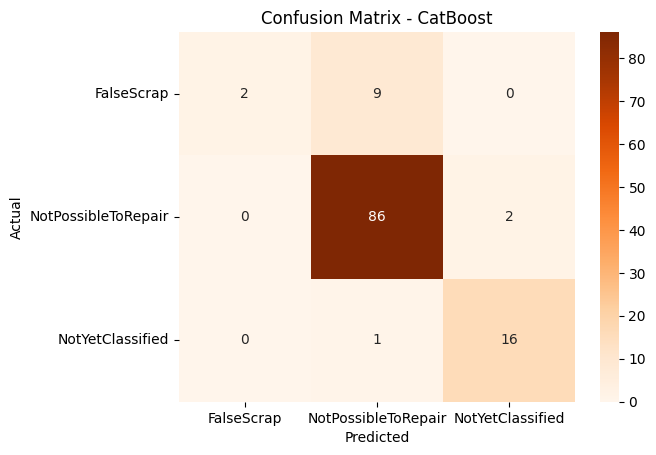


=== LightGBM ===
                     precision    recall  f1-score   support

         FalseScrap       0.43      0.55      0.48        11
NotPossibleToRepair       0.93      0.90      0.91        88
   NotYetClassified       0.94      0.94      0.94        17

           accuracy                           0.87       116
          macro avg       0.77      0.79      0.78       116
       weighted avg       0.88      0.87      0.88       116



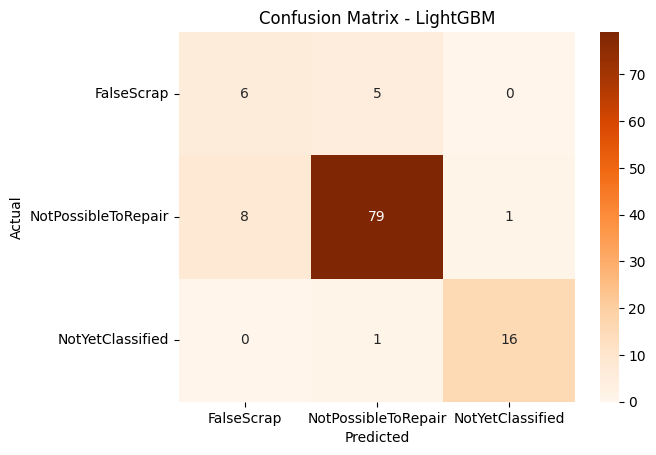


=== XGBoost ===
                     precision    recall  f1-score   support

         FalseScrap       0.42      0.45      0.43        11
NotPossibleToRepair       0.92      0.91      0.91        88
   NotYetClassified       0.94      0.94      0.94        17

           accuracy                           0.87       116
          macro avg       0.76      0.77      0.76       116
       weighted avg       0.88      0.87      0.87       116



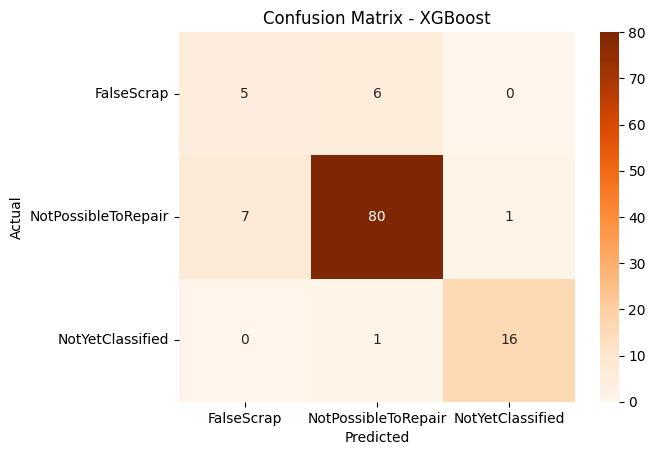


=== LSTM ===
                     precision    recall  f1-score   support

         FalseScrap       0.00      0.00      0.00        11
NotPossibleToRepair       0.88      0.98      0.92        88
   NotYetClassified       1.00      0.94      0.97        17

           accuracy                           0.88       116
          macro avg       0.63      0.64      0.63       116
       weighted avg       0.81      0.88      0.84       116



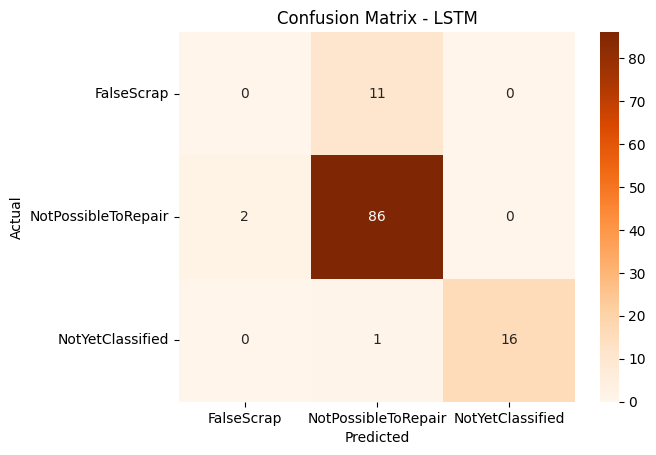

In [ ]:
evaluate_model(y_val, cat_model.predict(X_val), le, "CatBoost")
evaluate_model(y_val, lgb_model.predict(X_val), le, "LightGBM")
evaluate_model(y_val, xgb_model.predict(X_val), le, "XGBoost")
lstm_model.eval()
with torch.no_grad():
    tensor_val = torch.tensor(X_val_scaled, dtype=torch.float32)
    preds_lstm = lstm_model(tensor_val)
    lstm_preds = torch.argmax(preds_lstm, dim=1).numpy()
evaluate_model(y_val, lstm_preds, le, "LSTM")

## **Download CatBoost Model dalam format .pkl**

---



Alasan memilih catboost karena untuk masalah multikelas seperti ini, metrik terbaik untuk perbandingan adalah F1-score (macro avg). Metrik ini memberikan rata-rata F1-score dari semua kelas tanpa memihak pada kelas yang jumlah datanya banyak.

Catboost menghasilkan F1-score (macro avg) 0.82, yang tertinggi di antara semua model. Yang lebih penting, CatBoost menunjukkan performa yang paling seimbang. Ia memiliki F1-score yang baik untuk NotPossibleToRepair (0.94) dan NotYetClassified (0.91), dan yang terpenting, ia memiliki F1-score tertinggi (0.59) untuk kelas minoritas yang paling sulit, yaitu FalseScrap. Kemampuan untuk mendeteksi FalseScrap dengan presisi tinggi (83%) adalah keunggulan utamanya.



In [ ]:
best_model = cat_model
model_filename = 'Task3_model_repair_label.pkl'
joblib.dump(best_model, model_filename)

['Task3_model_repair_label.pkl']